# **DESAFIO 3 G2** 
# **Dataset Properati - Modelado de datos - Preliminar.**
---

<a id="section_toc"></a> 
## Tabla de Contenidos

[Intro](#sec_intro)

Observaciones preliminares dataset

$\hspace{.5cm}$[Importaciones y carga de dataset](#sec_imp)

$\hspace{.5cm}$[Analisis previos y distribuciones de variables](#sec_adv)
  
$\hspace{.5cm}$[Outliers](#sec_outliers)
  
$\hspace{.9cm}$[Outliers variable target](#sec_outliers_target)
  
$\hspace{.5cm}$[Imputaciones](#sec_imp)

$\hspace{.5cm}$[Variables dummies](#sec_dummies)

Depuracion

$\hspace{.5cm}$[Eliminacion de nulos y columnas](#section_re)

Modelado

$\hspace{.5cm}$[Borrado de registros duplicados](#section_drd)

$\hspace{.5cm}$[Borrado de registros sin información completa](#section_drii)



---



### Importacion y carga del dataset

In [1]:
import pandas as pd
import numpy as np
import re
import random

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [3]:
sns.set(font_scale=1.15)
sns.set_style("whitegrid")

In [4]:
pd.set_option('display.max_colwidth', 1500)
pd.set_option('display.max_rows', 400)

In [5]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [6]:
data_location = 'https://github.com/DHDSDesafios/DH_DS_desafio_2_properati/raw/master/data/properatid2caba.zip'
data = pd.read_csv(data_location, compression='zip', encoding="utf-8")

In [7]:
data.columns

Index(['Id_caso', 'property_type', 'place_with_parent_names', 'country_name',
       'state_name', 'lat-lon', 'lat', 'lon', 'price', 'currency',
       'price_aprox_local_currency', 'price_aprox_usd', 'floor', 'rooms',
       'expenses', 'description', 'title', 'Pais', 'Zona', 'Partido_barrio',
       'Localidad', 'Obs_localidad', 'place_name', 'geonames_id',
       'price_usd_per_m2', 'price_per_m2', 'surface_total_in_m2',
       'surface_covered_in_m2', 'cochera', 'piscina', 'parrilla', 'baulera',
       'balcon', 'terraza', 'jardin', 'lavadero', 'subte', 'seguridad',
       'metrobus'],
      dtype='object')

In [8]:
data.shape

(29380, 39)

In [9]:
data.sample(3)

,Id_caso,property_type,place_with_parent_names,country_name,state_name,lat-lon,lat,lon,price,currency,...,piscina,parrilla,baulera,balcon,terraza,jardin,lavadero,subte,seguridad,metrobus
25257,104348,apartment,|Argentina|Capital Federal|Villa Devoto|,Argentina,Capital Federal,"-34.607377976,-58.5141357004",-34.607378,-58.514136,185000.0,USD,...,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN
941,6104,apartment,|Argentina|Capital Federal|Monserrat|,Argentina,Capital Federal,"-34.610826,-58.384776",-34.610826,-58.384776,118000.0,USD,...,NaN,NaN,NaN,BALCON,1.0,NaN,NaN,NaN,NaN,NaN
1345,7708,PH,|Argentina|Capital Federal|Caballito|,Argentina,Capital Federal,"-34.6154989,-58.4637207",-34.615499,-58.463721,102000.0,USD,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0


---
## Analisis previos y distribuciones de variables

datosCol(serie) - Funcion que retorna diccionario con los datos de una Serie / Columna del DataFrame a analizar:

Campos:
 - nombre columna.
 - tipo de dato Pandas serie.
 - cantidad de registros en la serie.
 - cantidad de nulos en la serie.
 - cantidad de NO nulos en la serie.
 - porcentaje de No nulos en la serie.
 - cantidad de valores unicos en la serie.
 - valor mas repetido en la serie.
 - valor maximo en la serie.
 - valor minimos en la serie.
 - media, mediana y desvio estandar en la serie.
 - distribucion de cuantiles.
 - tipos de datos sobre los valores incluidos en la serie.

In [10]:
def datosCol(col=None):
    try:
        if col.dtype != object:
            return {
                    'nombre': col.name,
                    'series_dt': col.dtype,
                    'nulos': int(len(col) - col.describe()[0]), 
                    'nulos_porcentaje': round(col.isnull().sum() / col.size*100, 2),
                    'unicos': int(len(col.value_counts())),
                    'mas_repetido': col.value_counts().index[0],
                    'minimo': round(col.min(), 2),
                    'maximo': round(col.max(), 2),
                    'media': round(col.describe()[1], 2),
                    'mediana': col.median(),
                    'desvio': round(col.describe()[2], 2),
                    'q25': col.describe()[4],
                    'q50': col.describe()[5],
                    'q75': col.describe()[6],
                    'values_dt': [x for x in col.apply(lambda x: type(x)).value_counts().index]
                   }
        else:
            return {
                    'nombre': col.name,
                    'series_dt': col.dtype,
                    'nulos': col.isnull().sum(),
                    'nulos_porcentaje': round(col.isnull().sum() / col.size*100, 2),
                    'unicos': int(col.describe()[1]), 
                    'mas_repetido': col.describe()[2],
                    'nulos': col.isnull().sum(),
                    'frecuencia': int(col.describe()[3]),
                    'values_dt': [x for x in col.apply(lambda x: type(x)).value_counts().index]
                   }
    except:
        return 'use a valid pandas Series'

In [11]:
data_info = pd.DataFrame([datosCol(data[x]) for x in ['property_type', 'place_name', 'price_aprox_usd', 'floor', 'rooms',
                                                      'price_usd_per_m2', 'price_per_m2', 'surface_total_in_m2',
                                                      'surface_covered_in_m2', 'cochera', 'piscina', 'parrilla', 'baulera',
                                                      'balcon', 'terraza', 'jardin', 'lavadero', 'subte', 'seguridad', 'metrobus'] ])
data_info

,nombre,series_dt,nulos,nulos_porcentaje,unicos,mas_repetido,frecuencia,values_dt,minimo,maximo,media,mediana,desvio,q25,q50,q75
0,property_type,object,0,0.00,4,apartment,24713.0,[<class 'str'>],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,place_name,object,0,0.00,62,Belgrano,2745.0,[<class 'str'>],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,price_aprox_usd,float64,1532,5.21,5237,120000,NaN,[<class 'float'>],5103.61,46545445.00,263567.97,155000.00,452774.30,104724.465,155000.00,278000.00
3,floor,float64,26480,90.13,82,1,NaN,[<class 'float'>],1.00,2509.00,12.64,4.00,83.22,2.000,4.00,7.00
4,rooms,float64,11341,38.60,17,2,NaN,[<class 'float'>],1.00,22.00,2.55,2.00,1.47,1.000,2.00,3.00
5,price_usd_per_m2,float64,7227,24.60,10452,2500,NaN,[<class 'float'>],13.80,206333.33,3146.57,2486.41,3722.99,1988.950,2486.41,3094.27
6,price_per_m2,float64,2512,8.55,12115,2500,NaN,[<class 'float'>],3.21,2600000.00,3839.77,2727.27,18864.14,2177.420,2727.27,3440.00
7,surface_total_in_m2,float64,3638,12.38,734,40,NaN,[<class 'float'>],0.00,200000.00,116.88,62.00,1268.88,42.000,62.00,110.00
8,surface_covered_in_m2,float64,1170,3.98,620,30,NaN,[<class 'float'>],0.00,10958.00,91.43,55.00,203.58,38.000,55.00,95.00
9,cochera,float64,19299,65.69,1,1,NaN,[<class 'float'>],1.00,1.00,1.00,1.00,0.00,1.000,1.00,1.00


Estadarizacion de valores de amenities.

In [12]:
data.loc[data.balcon.notnull(), 'balcon'] = 1
data.loc[data.balcon.isnull(), 'balcon'] = 0
data["balcon"] =  pd.to_numeric(data["balcon"])

data.loc[data.cochera.isnull(), 'cochera'] = 0
data.cochera.astype('uint8')

data.loc[data.piscina.isnull(), 'piscina'] = 0
data.piscina.astype('uint8')

data.loc[data.lavadero.isnull(), 'lavadero'] = 0
data.lavadero.astype('uint8')

data.loc[data.parrilla.isnull(), 'parrilla'] = 0
data.parrilla.astype('uint8')

data.loc[data.terraza.isnull(), 'terraza'] = 0
data.terraza.astype('uint8')

data.loc[data.jardin.isnull(), 'jardin'] = 0
data.jardin.astype('uint8')

data.loc[data.baulera.isnull(), 'baulera'] = 0
data.baulera.astype('uint8')

data.loc[data.seguridad.isnull(), 'seguridad'] = 0
data.seguridad.astype('uint8')

data.loc[data.metrobus.isnull(), 'metrobus'] = 0
data.metrobus.astype('uint8')

data.loc[data.subte.isnull(), 'subte'] = 0
data.subte.astype('uint8')

0        0
1        0
2        0
3        0
4        0
        ..
29375    0
29376    0
29377    0
29378    0
29379    1
Name: subte, Length: 29380, dtype: uint8

Graficos basicos de visualizacion

In [13]:
prop_apartment = data.property_type == 'apartment'
prop_store = data.property_type == 'store'
prop_ph = data.property_type == 'PH'
prop_house = data.property_type == 'house'

### Distribuciones basicas de variables numericas continuas

 * 'price_per_m2'
 * 'price_usd_per_m2'
 * 'surface_total_in_m2'
 * 'surface_covered_in_m2'

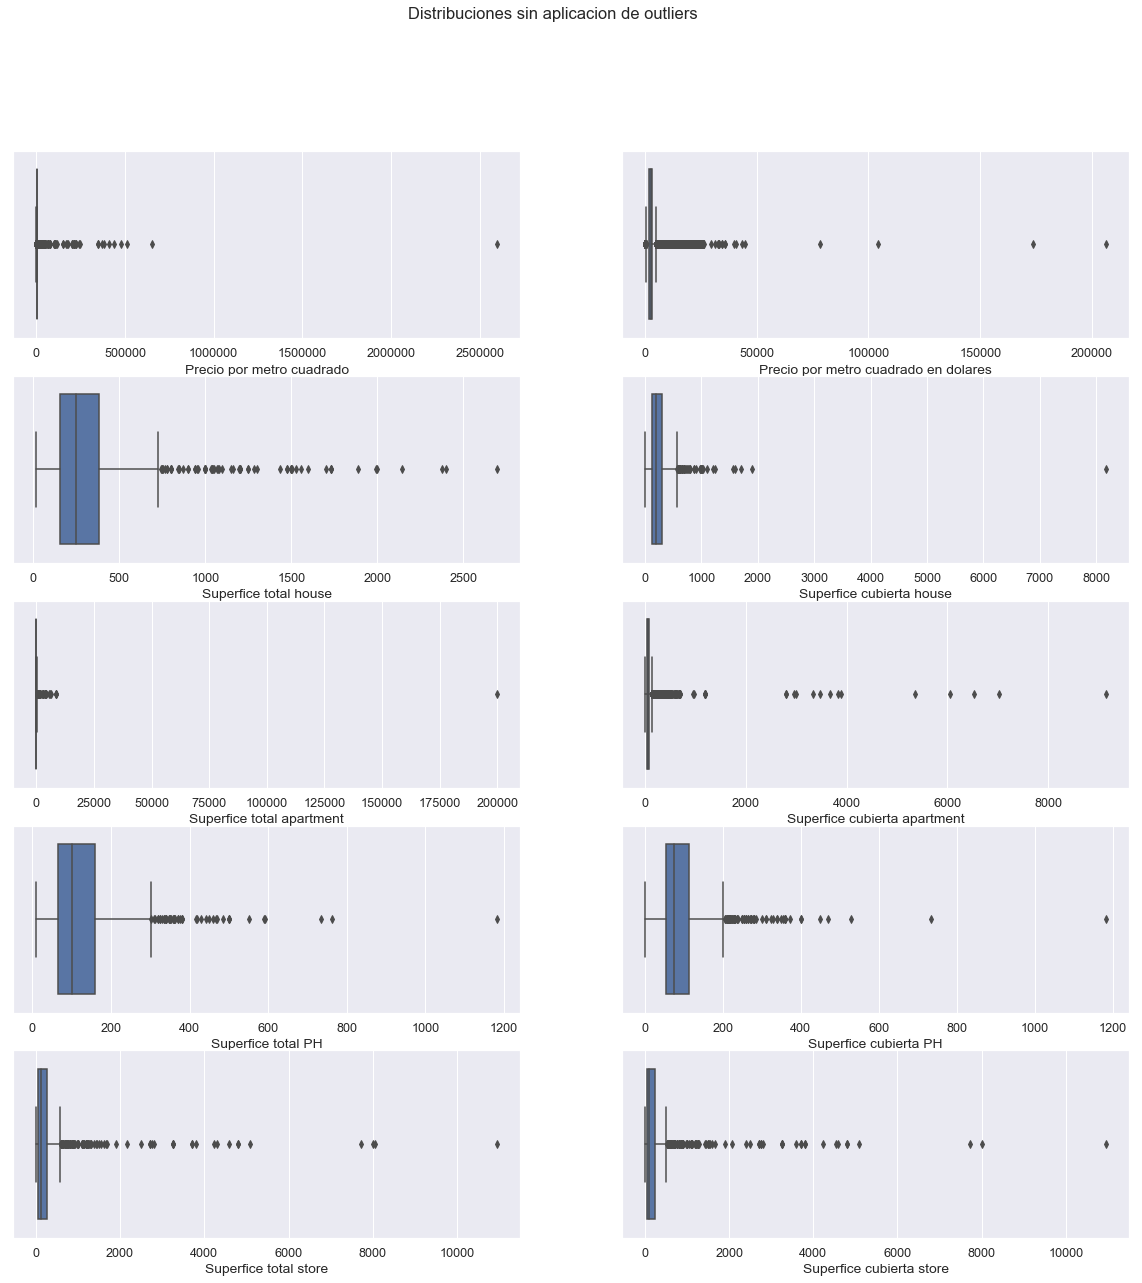

In [14]:
sns.set_style("darkgrid")
fig, axs = plt.subplots(5,2,figsize=(20,20))
fig.suptitle('Distribuciones sin aplicacion de outliers')

sns.boxplot(x='price_per_m2', data=data, ax=axs[0,0])
axs[0,0].set(xlabel='Precio por metro cuadrado') 

sns.boxplot(x='price_usd_per_m2', data=data, ax=axs[0,1])
axs[0,1].set(xlabel='Precio por metro cuadrado en dolares')

sns.boxplot(x='surface_total_in_m2', data=data.loc[prop_house, :], ax=axs[1,0])
axs[1,0].set(xlabel='Superfice total house')

sns.boxplot(x='surface_covered_in_m2', data=data.loc[prop_house, :], ax=axs[1,1])
axs[1,1].set(xlabel='Superfice cubierta house')

sns.boxplot(x='surface_total_in_m2', data=data.loc[prop_apartment, :], ax=axs[2,0])
axs[2,0].set(xlabel='Superfice total apartment')

sns.boxplot(x='surface_covered_in_m2', data=data.loc[prop_apartment, :], ax=axs[2,1])
axs[2,1].set(xlabel='Superfice cubierta apartment')

sns.boxplot(x='surface_total_in_m2', data=data.loc[prop_ph, :], ax=axs[3,0])
axs[3,0].set(xlabel='Superfice total PH')

sns.boxplot(x='surface_covered_in_m2', data=data.loc[prop_ph, :], ax=axs[3,1])
axs[3,1].set(xlabel='Superfice cubierta PH')

sns.boxplot(x='surface_total_in_m2', data=data.loc[prop_store, :], ax=axs[4,0])
axs[4,0].set(xlabel='Superfice total store')

sns.boxplot(x='surface_covered_in_m2', data=data.loc[prop_store, :], ax=axs[4,1])
axs[4,1].set(xlabel='Superfice cubierta store')

plt.show()

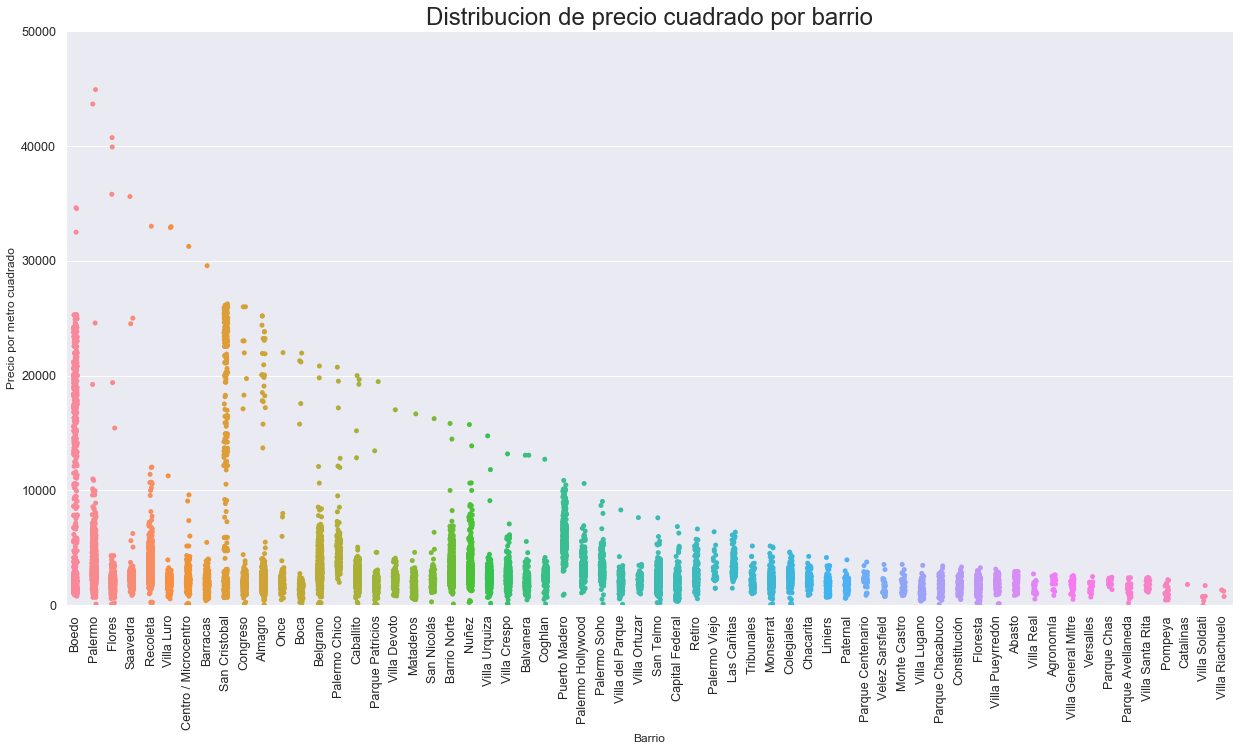

In [15]:
g = sns.catplot(data=data.sort_values(by=['price_usd_per_m2'], ascending=False), x='place_name', y='price_usd_per_m2', height=9, aspect=2)
g.set_xticklabels(rotation=90)
g.set(ylim=(0,50000))
plt.title("Distribucion de precio cuadrado por barrio", size=24)
plt.xlabel('Barrio', size=12)
plt.ylabel('Precio por metro cuadrado', size=12)
plt.show()

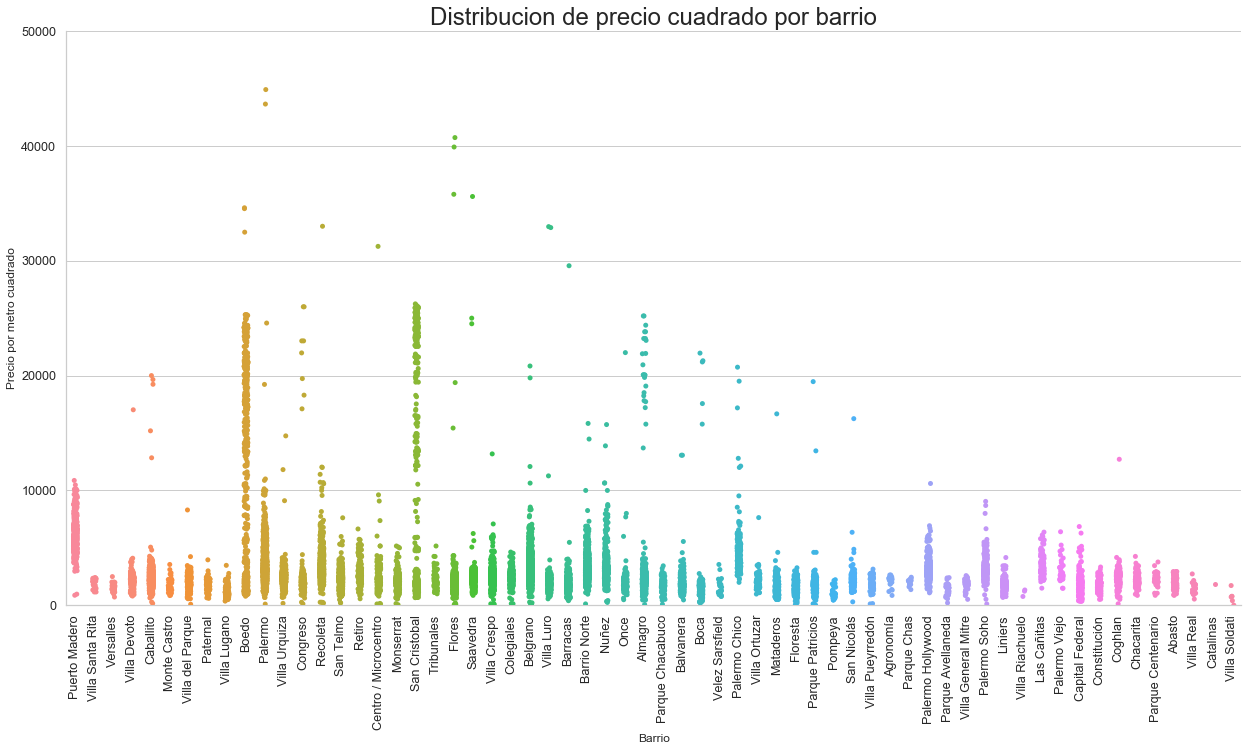

In [16]:
sns.set_style("whitegrid")
g = sns.catplot(data=data.sort_values(by=['price_per_m2'], ascending=False), x='place_name', y='price_usd_per_m2', height=9, aspect=2)
g.set_xticklabels(rotation=90)
g.set(ylim=(0,50000))
plt.title("Distribucion de precio cuadrado por barrio", size=24)
plt.xlabel('Barrio', size=12)
plt.ylabel('Precio por metro cuadrado', size=12)
plt.show()

catplot con distribucion de precios por metro cuadrado desagregado por barrio.
llama la atencion la cantidad de registros que evidencian un alta cantidad y alto valor de precio por metro cuadrado en barrios que no son los lideres en precio

se corto el tope maximo de la escala solo a fin ilustrativo, para evidenciar claramete el estado de la distribucion

https://www.reporteinmobiliario.com/nuke/article3269-datos-estadisticos-de-precios-en-la-ciudad-de-buenos-aires.html
    
http://www.maureinmobiliaria.com/metro-cuadrado/
    
https://www.on24.com.ar/negocios/a-cuanto-esta-el-metro-cuadrado-hoy-en-caba-y-gran-buenos-aires/
    
https://fortuna.perfil.com/2019-11-21-207654-vivienda-a-cuanto-esta-el-m2-segun-los-barrios-en-caba/

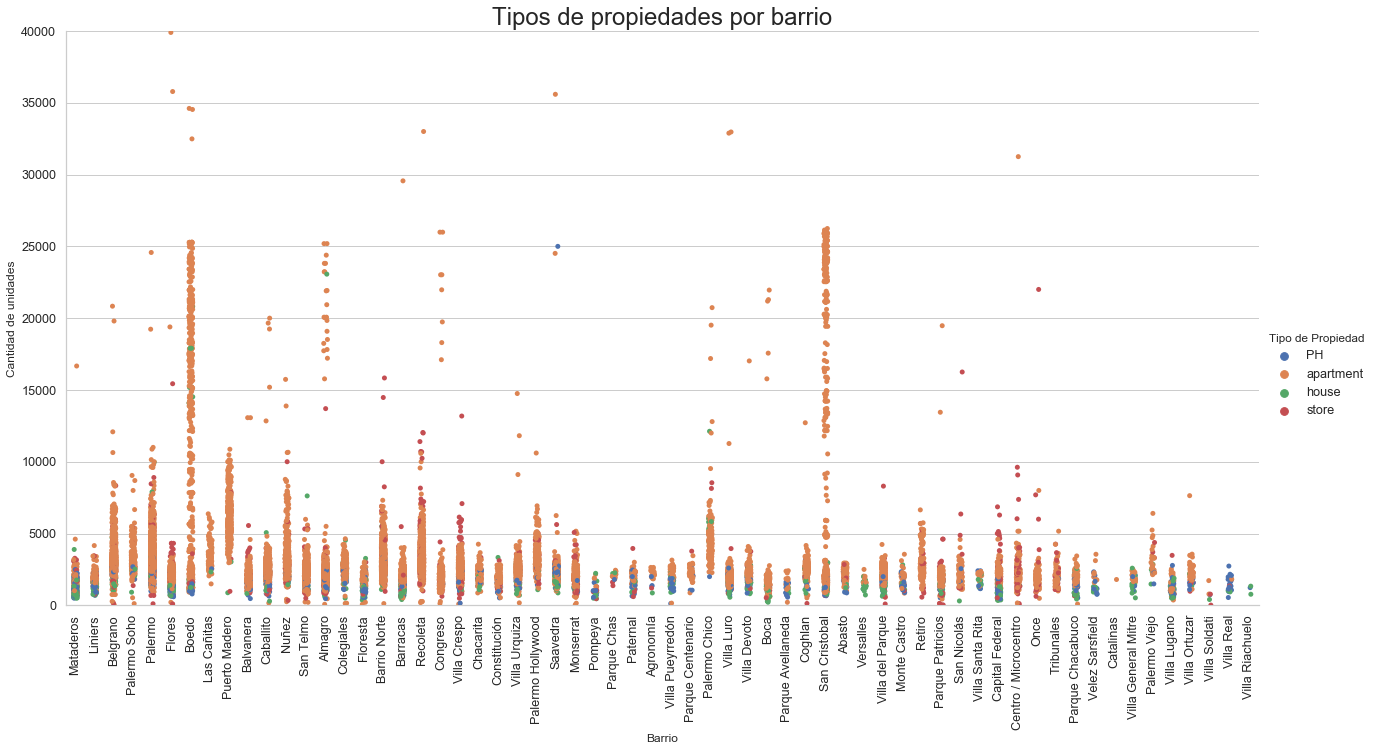

In [17]:
#g = sns.catplot(x='place_name', hue='property_type', kind='count', data=data, height=9, aspect=2, legend_out=True)
g = sns.catplot(x='place_name', y='price_usd_per_m2', hue='property_type', data=data, height=9, aspect=2, legend_out=True)
g.set(ylim=(0,40000))
g.set_xticklabels(rotation=90)
plt.title("Tipos de propiedades por barrio", size=24)
plt.xlabel('Barrio', size=12)
plt.ylabel('Cantidad de unidades', size=12)
g._legend.set_title('Tipo de Propiedad')

plt.show()

Distribucion de amenities por barrio

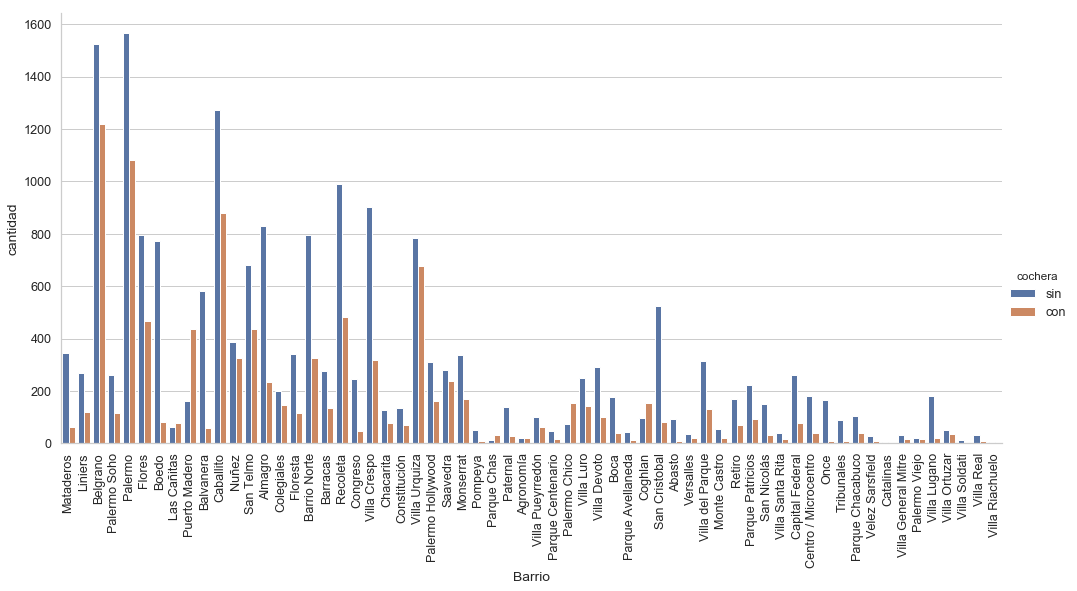

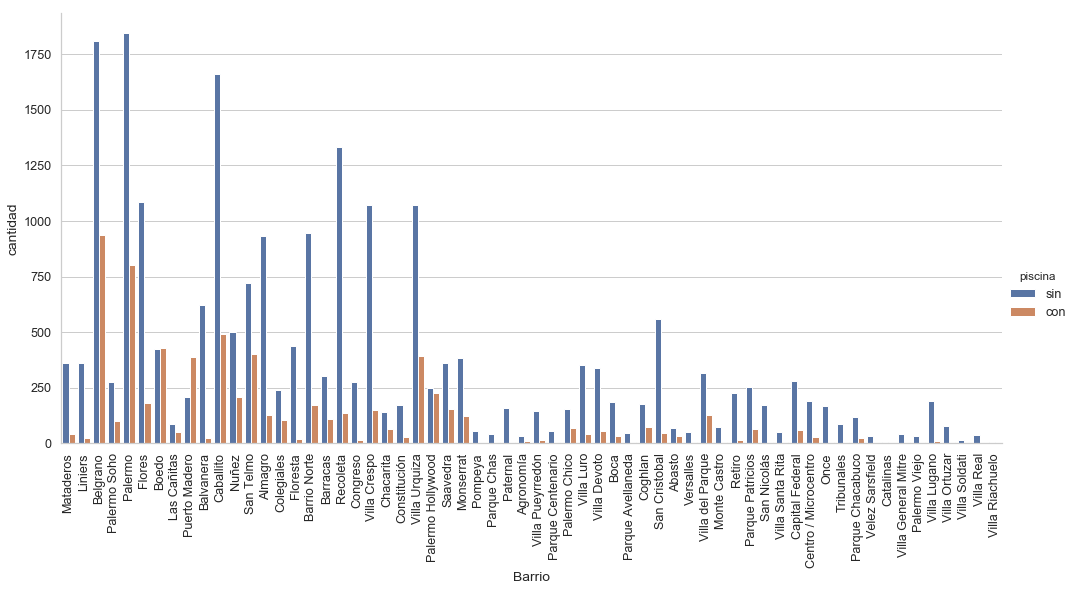

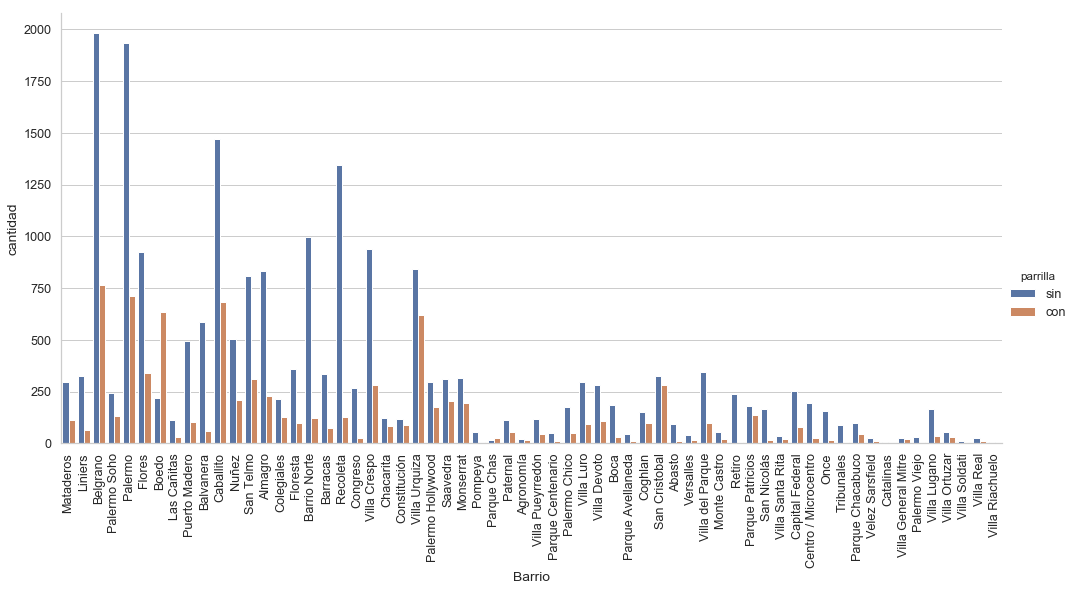

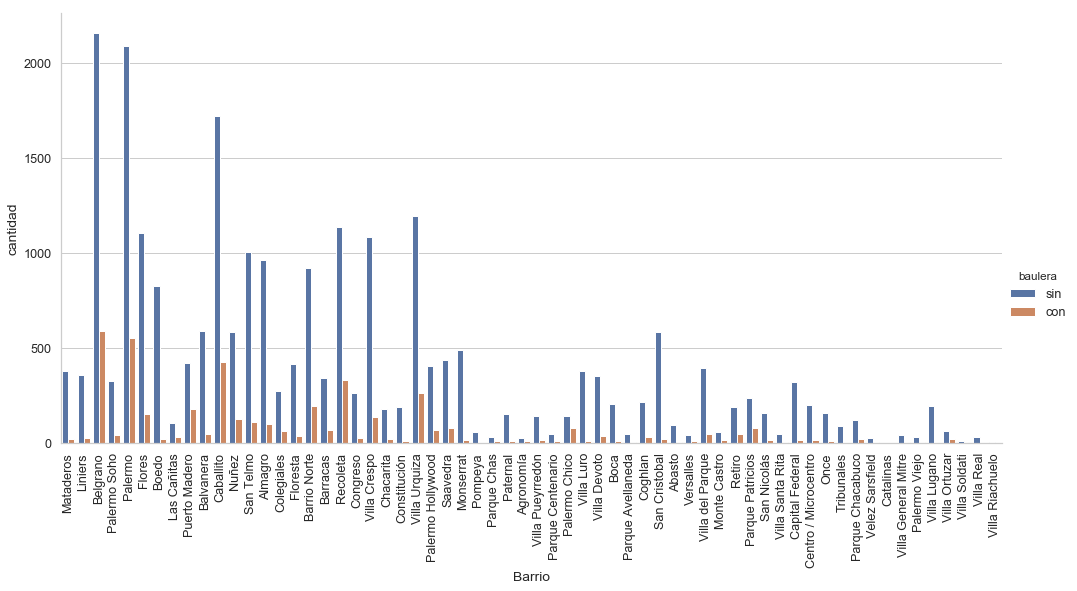

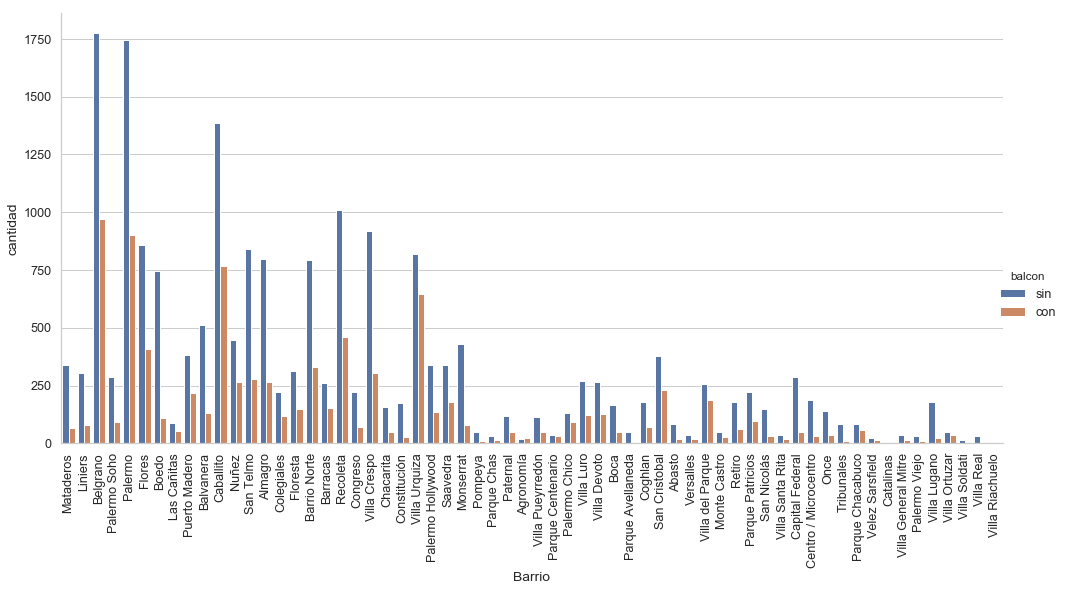

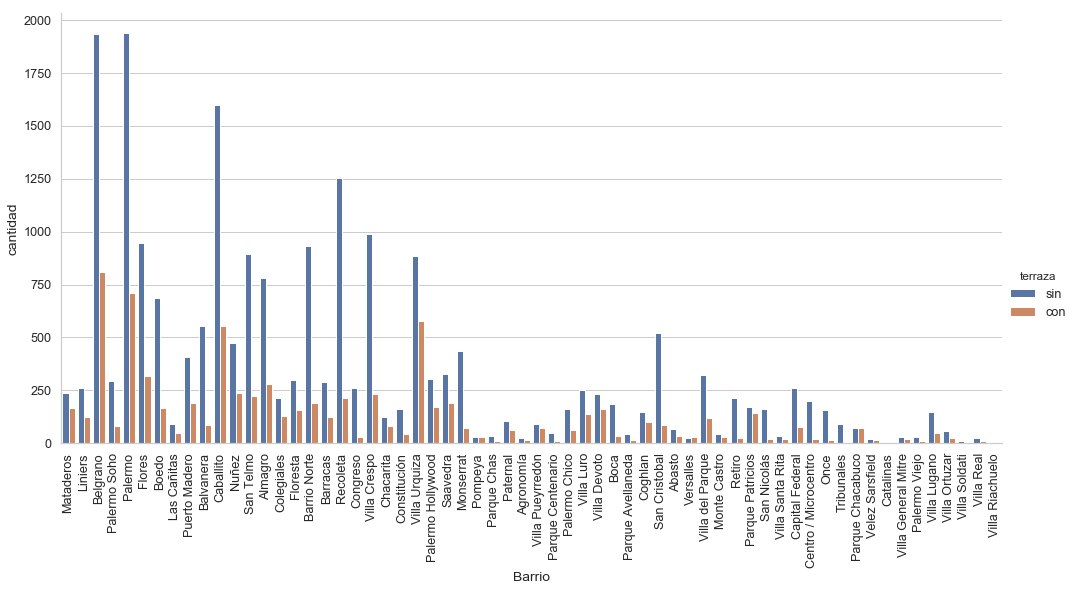

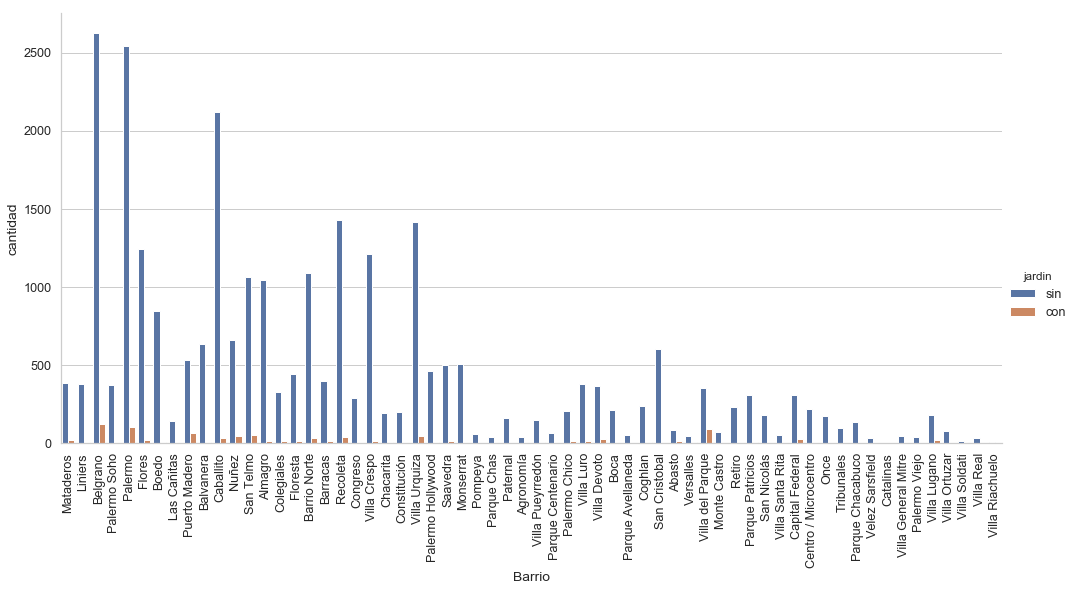

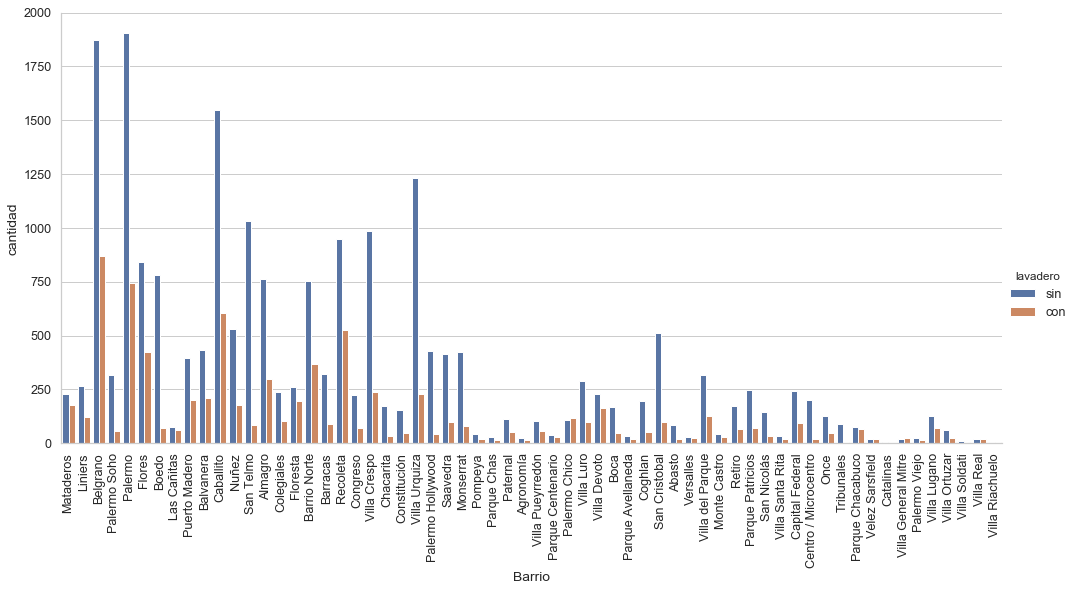

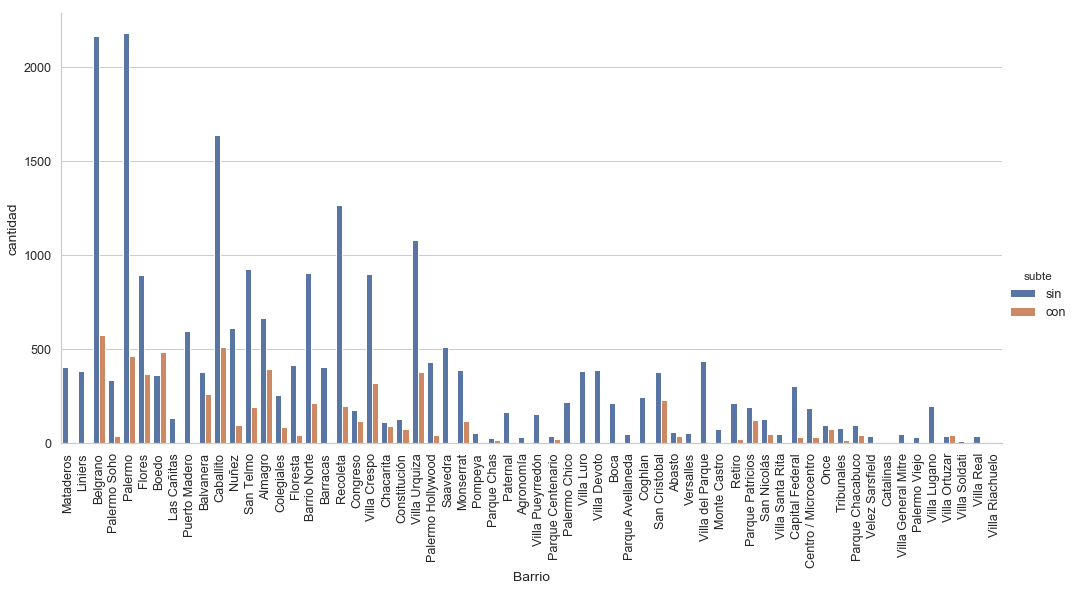

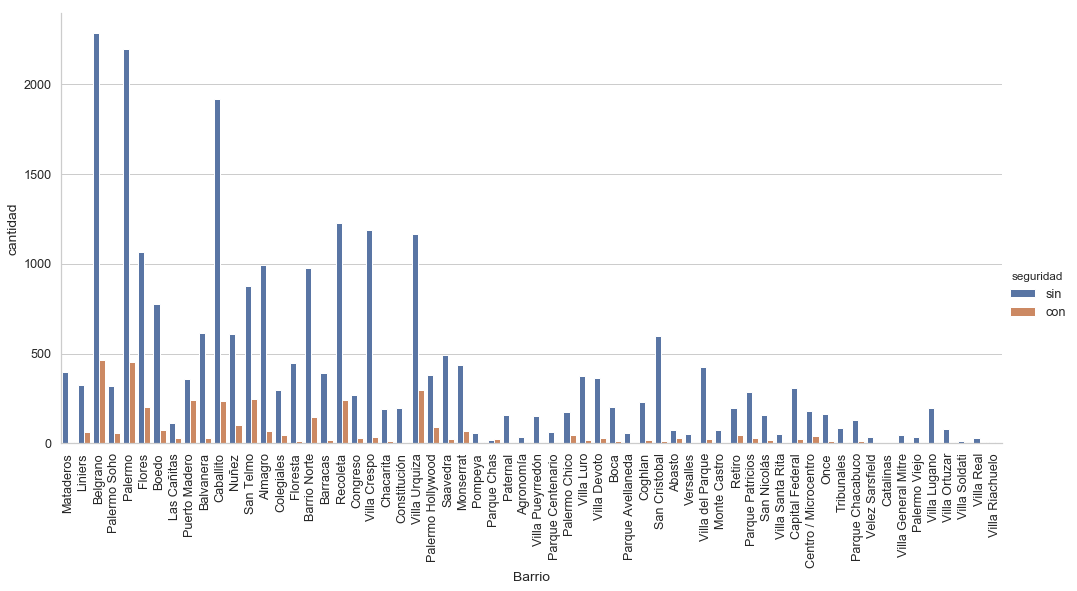

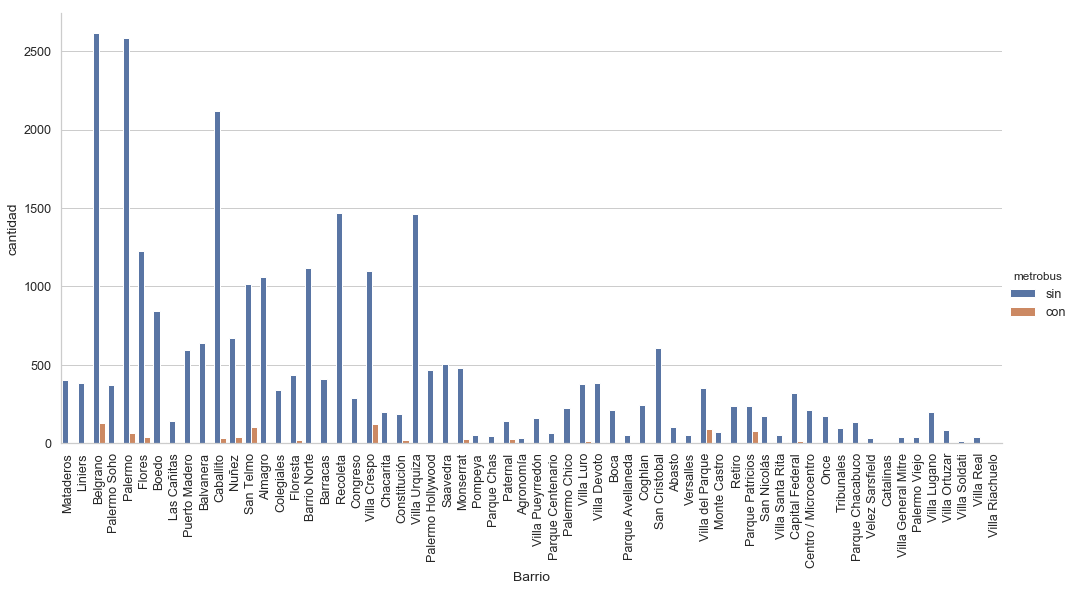

In [18]:
for x in data.columns[28:]:
    g = sns.catplot(x='place_name', hue=x, kind='count', data=data, height=7, aspect=2, legend_out=True)
    g.set_xticklabels(rotation=90)
    g.set(xlabel='Barrio', ylabel='cantidad')
    g._legend.set_title(x)
    new_labels = ['sin', 'con']
    for t, l in zip(g._legend.texts, new_labels): 
        t.set_text(l)

Correlacion entre variables numericas continuas con variable target.

In [19]:
data.loc[:, ['price_aprox_usd', 'price_usd_per_m2', 'surface_covered_in_m2', 'surface_total_in_m2', 'price_per_m2']].corr()

,price_aprox_usd,price_usd_per_m2,surface_covered_in_m2,surface_total_in_m2,price_per_m2
price_aprox_usd,1.000000,0.299240,0.444095,0.675114,0.092777
price_usd_per_m2,0.299240,1.000000,-0.047114,-0.014624,0.534638
surface_covered_in_m2,0.444095,-0.047114,1.000000,0.658421,-0.021779
surface_total_in_m2,0.675114,-0.014624,0.658421,1.000000,0.038001
price_per_m2,0.092777,0.534638,-0.021779,0.038001,1.000000


Correlacion entre variables numericas discretas con variable target.

In [20]:
data.loc[:, ['price_usd_per_m2', 'cochera', 'piscina', 'parrilla', 'baulera', 'balcon', 'terraza', 'jardin', 'lavadero', 'subte', 'seguridad', 'metrobus']].corr()

,price_usd_per_m2,cochera,piscina,parrilla,baulera,balcon,terraza,jardin,lavadero,subte,seguridad,metrobus
price_usd_per_m2,1.000000,-0.006225,0.089500,0.162107,-0.004820,0.043572,-0.050938,-0.006867,-0.087856,0.054266,0.054678,-0.037496
cochera,-0.006225,1.000000,0.268035,0.211302,0.299215,0.236613,0.136142,0.065609,0.062795,-0.077577,0.233149,-0.029805
piscina,0.089500,0.268035,1.000000,0.379803,0.114733,0.106445,0.109914,0.132456,-0.078120,0.004874,0.275207,-0.010327
parrilla,0.162107,0.211302,0.379803,1.000000,0.059655,0.075490,0.284524,0.056150,-0.047983,0.035348,0.111212,-0.014175
baulera,-0.004820,0.299215,0.114733,0.059655,1.000000,0.631777,0.080706,0.052823,0.210650,0.008817,0.187072,-0.004472
balcon,0.043572,0.236613,0.106445,0.075490,0.631777,1.000000,0.143050,0.076075,0.161583,0.000822,0.167458,0.039200
terraza,-0.050938,0.136142,0.109914,0.284524,0.080706,0.143050,1.000000,0.076853,0.090028,-0.010656,0.094020,0.018945
jardin,-0.006867,0.065609,0.132456,0.056150,0.052823,0.076075,0.076853,1.000000,0.057502,-0.042859,0.086155,0.054200
lavadero,-0.087856,0.062795,-0.078120,-0.047983,0.210650,0.161583,0.090028,0.057502,1.000000,0.004940,0.047755,-0.014909
subte,0.054266,-0.077577,0.004874,0.035348,0.008817,0.000822,-0.010656,-0.042859,0.004940,1.000000,0.026847,0.192602


### FALTA GRAFICAR MINIMO HEATMAP Y PAIRPLOT
## PENSAR RELACIONES ENTRE VARIABLES

---

### TRABAJO CON OUTLIERS

#### Removedor de outliers

completar proceso de remocion de outliers

In [21]:
def remove_outlier(df_in, qt1, qt3, iqrout, col_name, mask1, var1, mask2=None, var2=None):
    '''
    Calculo de outliers

    Parameters
    ----------
    df_in : dataFrame
        dataFrame utilizado para extraer variables de filtro y mascaras.
    qt1, qt3: float
        Cuantil inferior y superior (0 a 1).
    iqrout: float
        Margen exterior a iqr (1.5 o 3 recomendado)
    var1, var2: str
        Nombre de columnas de dataFrame ingresado como parametro para aplicar filtro sobre los datos.
    mask1, mask2: str
        Valores para utilizar con las columnas de filtro para generar mascaras booleanas.
    col_name: str
        Variable a aplicar los outliers.
    
    Output
    ------
    dataFrame filtrado por parametros con los outliers aplicados.

    Example
    ----------
    remove_outlier(data, 0.25, 0.75, 1.5, 'price_usd_per_m2', 'Belgrano', 'place_name', 'PH', 'property_type')
    
    '''
    
    if (mask2 is None and var2 is not None) | (mask2 is not None and var2 is None):
        return 'you must set second mask with second variable'
    elif mask2 is None and var2 is None:
        var_mask = df_in[var1] == mask1
    else:
        var_mask = (df_in[var1] == mask1) & (df_in[var2] == mask2)
        
    q1 = df_in.loc[var_mask, col_name].quantile(qt1)
    q3 = df_in.loc[var_mask, col_name].quantile(qt3)
    
    iqr = q3-q1 #Interquartile range
    
    fence_low  = q1-iqrout*iqr
    fence_high = q3+iqrout*iqr
    
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high) & var_mask]
    
    return df_out

Primer pasada remocion de outliers variable target

In [22]:
df_final = pd.DataFrame()
place_name_list = data.place_name.unique()
prop_type_list = data.property_type.unique()
for pn in place_name_list:
    for pt in prop_type_list:
        df_temp = remove_outlier(data, 0.05, 0.95, 1.5, 'price_usd_per_m2', pn, 'place_name', pt, 'property_type')
        df_final = df_final.append(df_temp)

In [23]:
data = df_final

Primer pasada remocion variable price_per_m2

In [24]:
df_final = pd.DataFrame()
place_name_list = data.place_name.unique()
prop_type_list = data.property_type.unique()
for pn in place_name_list:
    for pt in prop_type_list:
        df_temp = remove_outlier(data, 0.05, 0.95, 1.5, 'price_per_m2', pn, 'place_name', pt, 'property_type')
        df_final = df_final.append(df_temp)

In [25]:
data = df_final

Primer pasada remocion variable surface_total_in_m2

In [26]:
df_final = pd.DataFrame()
place_name_list = data.place_name.unique()
prop_type_list = data.property_type.unique()
for pn in place_name_list:
    for pt in prop_type_list:
        df_temp = remove_outlier(data, 0.05, 0.95, 1.5, 'surface_total_in_m2', pn, 'place_name', pt, 'property_type')
        df_final = df_final.append(df_temp)

In [27]:
data = df_final

Primer pasada remocion variable surface_covered_in_m2

In [28]:
df_final = pd.DataFrame()
place_name_list = data.place_name.unique()
prop_type_list = data.property_type.unique()
for pn in place_name_list:
    for pt in prop_type_list:
        df_temp = remove_outlier(data, 0.05, 0.95, 1.5, 'surface_covered_in_m2', pn, 'place_name', pt, 'property_type')
        df_final = df_final.append(df_temp)

In [29]:
data = df_final

In [30]:
data.loc[:, ['price_aprox_usd', 'price_usd_per_m2', 'surface_covered_in_m2', 'surface_total_in_m2', 'price_per_m2']].corr()

,price_aprox_usd,price_usd_per_m2,surface_covered_in_m2,surface_total_in_m2,price_per_m2
price_aprox_usd,1.000000,0.374731,0.614712,0.608417,0.190819
price_usd_per_m2,0.374731,1.000000,-0.060283,-0.087209,0.453375
surface_covered_in_m2,0.614712,-0.060283,1.000000,0.939609,-0.036609
surface_total_in_m2,0.608417,-0.087209,0.939609,1.000000,-0.016516
price_per_m2,0.190819,0.453375,-0.036609,-0.016516,1.000000


In [31]:
property_type_dummies = pd.get_dummies(data.property_type, prefix='prop_type', drop_first = True)
data = pd.concat([data, property_type_dummies], axis=1)

In [32]:
place_name_dummies = pd.get_dummies(data.place_name, prefix='pn', drop_first = True)
data = pd.concat([data, place_name_dummies], axis=1)

In [33]:
data.shape

(21059, 102)

Imputacion deliberada de variables floor y rooms

In [34]:
nulos_piso = data.floor.isnull()
data.loc[nulos_piso, "floor" ] = 4

nulos_rooms = data.rooms.isnull()
data.loc[nulos_rooms, "rooms" ] = 2

---
notebook fer

In [35]:
precio_m2_barrio = data.groupby(['place_name','property_type']).agg({'price_usd_per_m2':  ['max']})
display(precio_m2_barrio.shape)
display(precio_m2_barrio.sort_values(by = [('price_usd_per_m2', 'max')], ascending=False).head(20))

(212, 1)

,,price_usd_per_m2
,,max
place_name,property_type,
Boedo,apartment,34608.00
San Cristobal,apartment,26241.64
Once,store,22000.00
Boedo,house,20784.21
San Nicolás,store,16250.00
Barrio Norte,store,15833.33
Villa Crespo,store,13181.82
Palermo Chico,apartment,12796.21


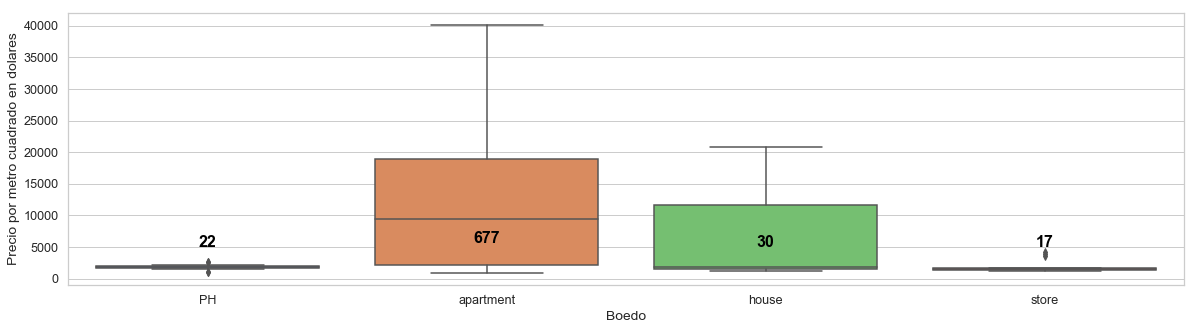

In [36]:
# Distrubucion precios barrio Boedo

plt.subplots(figsize=(20,5))
mask_place_name = data.place_name == 'Boedo'
g = sns.boxplot(x='property_type',y='price_per_m2',data=data.loc[mask_place_name, :], palette='muted')
g.set(xlabel='Boedo', ylabel='Precio por metro cuadrado en dolares')

valores = data.loc[mask_place_name, 'property_type'].value_counts().sort_index()
y_valores = 5000

for xtick in g.get_xticks():
    g.text(xtick, valores[xtick]+ y_valores, valores[xtick], horizontalalignment='center',fontsize=16,color='black',weight='bold')

plt.show()

In [37]:
df_final = pd.DataFrame()
mask_place_name = data.place_name == 'Boedo'
mask_property_type = data.property_type == 'apartment'
place_name_list = data.loc[mask_place_name&mask_property_type].place_name.unique()
prop_type_list =  data.loc[mask_place_name&mask_property_type].property_type.unique()
for pn in place_name_list:
    for pt in prop_type_list:
        df_temp = remove_outlier(data, 0.25, 0.75, 1.5, 'price_usd_per_m2', pn, 'place_name', pt, 'property_type')
        df_final = df_final.append(df_temp)

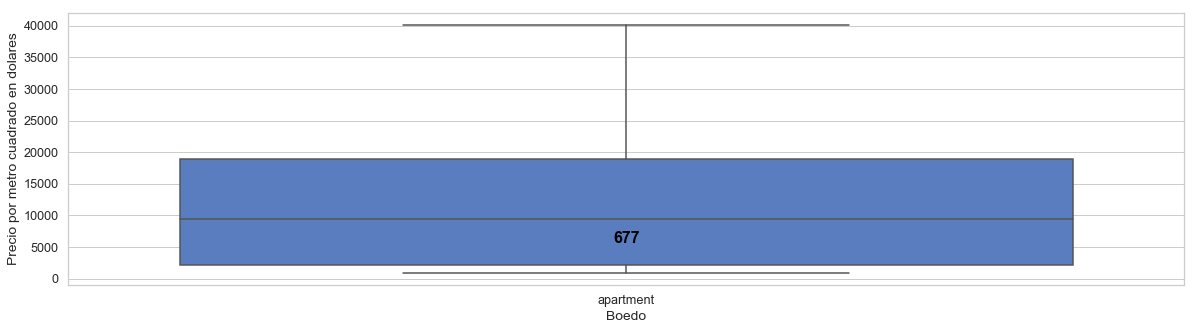

In [38]:
plt.subplots(figsize=(20,5))
mask_place_name = df_final.place_name == 'Boedo'
g = sns.boxplot(x='property_type',y='price_per_m2',data=df_final.loc[mask_place_name, :], palette='muted')
g.set(xlabel='Boedo', ylabel='Precio por metro cuadrado en dolares')

valores = df_final.loc[mask_place_name, 'property_type'].value_counts().sort_index()
y_valores = 5000

for xtick in g.get_xticks():
    g.text(xtick, valores[xtick]+ y_valores, valores[xtick], horizontalalignment='center',fontsize=16,color='black',weight='bold')

plt.show()

In [39]:
df_final1 = pd.DataFrame()
mask_precio_max = df_final.price_usd_per_m2 < 3500
mask_place_name = df_final.place_name == 'Boedo'
mask_property_type = df_final.property_type == 'apartment'
place_name_list = df_final.loc[mask_place_name&mask_property_type].place_name.unique()
prop_type_list =  df_final.loc[mask_place_name&mask_property_type].property_type.unique()
for pn in place_name_list:
    for pt in prop_type_list:
        df_temp = remove_outlier(df_final.loc[mask_precio_max], 0.10, 0.90, 1.5, 'price_usd_per_m2', pn, 'place_name', pt, 'property_type')
        df_final1 = df_final1.append(df_temp)

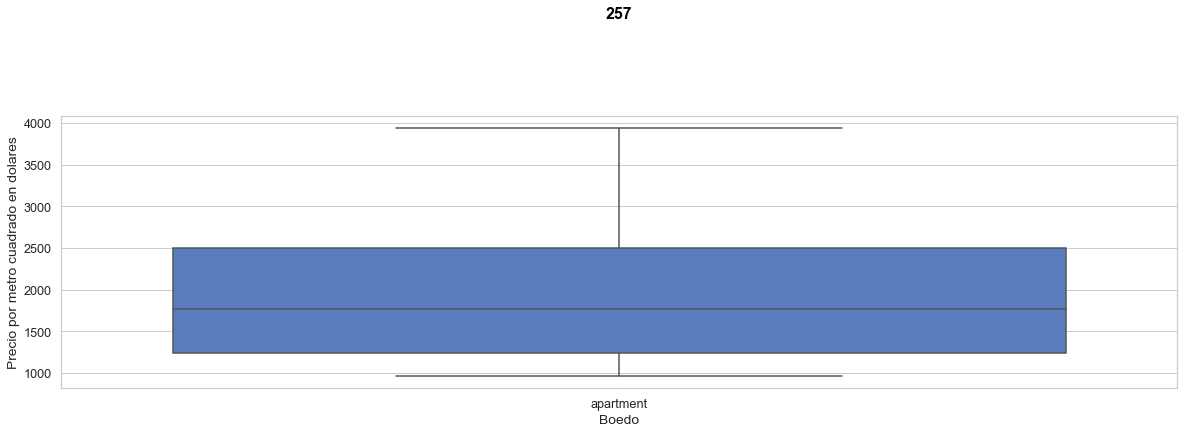

In [40]:
plt.subplots(figsize=(20,5))
mask_place_name = df_final1.place_name == 'Boedo'
g = sns.boxplot(x='property_type',y='price_per_m2',data=df_final1.loc[mask_place_name, :], palette='muted')
g.set(xlabel='Boedo', ylabel='Precio por metro cuadrado en dolares')

valores = df_final1.loc[mask_place_name, 'property_type'].value_counts().sort_index()
y_valores = 5000

for xtick in g.get_xticks():
    g.text(xtick, valores[xtick]+ y_valores, valores[xtick], horizontalalignment='center',fontsize=16,color='black',weight='bold')

plt.show()

In [43]:
precio_m2_barrio_Boedo = df_final1.loc[:,['price_usd_per_m2','Id_caso']]
display(precio_m2_barrio_Boedo.shape)
display(precio_m2_barrio_Boedo.sort_values(by = [('price_usd_per_m2')], ascending=False).head(10))

(257, 2)

,price_usd_per_m2,Id_caso
5736,3340.00,25668
5730,3337.14,25661
5750,3337.14,25684
5773,3244.57,25708
25362,3014.10,105336
25364,3014.10,105347
10882,2888.89,45208
25356,2877.89,105298
25358,2861.87,105308
25368,2843.99,105362


In [44]:
# borro todos los de Boedo / Departamento
mask_place_name = data.place_name == 'Boedo'
mask_property_type = data.property_type == 'apartment'
data = data.drop(data.loc[mask_place_name&mask_property_type].index)

In [45]:
# append todos los de Boedo / Departamento nuevos (sin outliers)
data = data.append(df_final1)

In [46]:
# valido
mask_place_name = data.place_name == 'Boedo'
mask_property_type = data.property_type == 'apartment'
data.loc[mask_place_name&mask_property_type]

,Id_caso,property_type,place_with_parent_names,country_name,state_name,lat-lon,lat,lon,price,currency,...,pn_Villa Lugano,pn_Villa Luro,pn_Villa Ortuzar,pn_Villa Pueyrredón,pn_Villa Real,pn_Villa Riachuelo,pn_Villa Santa Rita,pn_Villa Soldati,pn_Villa Urquiza,pn_Villa del Parque
11,35,apartment,|Argentina|Capital Federal|Boedo|,Argentina,Capital Federal,"-34.6217693287,-58.4221081951",-34.621769,-58.422108,145000.0,USD,...,0,0,0,0,0,0,0,0,0,0
23,66,apartment,|Argentina|Capital Federal|Boedo|,Argentina,Capital Federal,"-34.6187769485,-58.4026450688",-34.618777,-58.402645,72900.0,USD,...,0,0,0,0,0,0,0,0,0,0
1028,6482,apartment,|Argentina|Capital Federal|Boedo|,Argentina,Capital Federal,"-34.6234762,-58.4121858",-34.623476,-58.412186,75000.0,USD,...,0,0,0,0,0,0,0,0,0,0
1528,8216,apartment,|Argentina|Capital Federal|Boedo|,Argentina,Capital Federal,"-34.6269038,-58.4185866",-34.626904,-58.418587,195000.0,USD,...,0,0,0,0,0,0,0,0,0,0
2028,10380,apartment,|Argentina|Capital Federal|Boedo|,Argentina,Capital Federal,"-34.6216482,-58.4251815",-34.621648,-58.425181,73000.0,USD,...,0,0,0,0,0,0,0,0,0,0
2219,11047,apartment,|Argentina|Capital Federal|Boedo|,Argentina,Capital Federal,"-34.6353459509,-58.412231327",-34.635346,-58.412231,139500.0,USD,...,0,0,0,0,0,0,0,0,0,0
2536,12682,apartment,|Argentina|Capital Federal|Boedo|,Argentina,Capital Federal,NaN,NaN,NaN,73000.0,USD,...,0,0,0,0,0,0,0,0,0,0
2746,13450,apartment,|Argentina|Capital Federal|Boedo|,Argentina,Capital Federal,"-34.6254176,-58.4160723",-34.625418,-58.416072,220000.0,USD,...,0,0,0,0,0,0,0,0,0,0
3174,15614,apartment,|Argentina|Capital Federal|Boedo|,Argentina,Capital Federal,"-34.630618,-58.4195974",-34.630618,-58.419597,42500.0,USD,...,0,0,0,0,0,0,0,0,0,0
3223,15822,apartment,|Argentina|Capital Federal|Boedo|,Argentina,Capital Federal,"-34.6235775,-58.4148058",-34.623578,-58.414806,85000.0,USD,...,0,0,0,0,0,0,0,0,0,0


In [47]:
# Borro grafico de distribucion de precios boedo casa - redundante ya que esta arriba

In [48]:
# Distribucion precios Bodeo Casa

df_final = pd.DataFrame()
mask_place_name = data.place_name == 'Boedo'
mask_property_type = data.property_type == 'house'
place_name_list = data.loc[mask_place_name&mask_property_type].place_name.unique()
prop_type_list =  data.loc[mask_place_name&mask_property_type].property_type.unique()
for pn in place_name_list:
    for pt in prop_type_list:
        df_temp = remove_outlier(data, 0.25, 0.75, 1.5, 'price_usd_per_m2', pn, 'place_name', pt, 'property_type')
        df_final = df_final.append(df_temp)

In [49]:
# Borro grafico de distribucion de precios Boedo Casa - 1ra pasada outliers - df_final

In [50]:
precio_m2_barrio = df_final.loc[:,['price_usd_per_m2','Id_caso']]
display(precio_m2_barrio)
display(precio_m2_barrio.sort_values(by = [('price_usd_per_m2')], ascending=False).head(10))

,price_usd_per_m2,Id_caso
15,1091.27,51
3596,1649.48,17392
3756,1550.39,18013
3881,909.09,18524
5194,1065.22,24532
5467,880.95,25192
5468,1184.21,25193
5651,15176.67,25562
5652,14520.00,25563
5653,14093.33,25564


,price_usd_per_m2,Id_caso
6426,20784.21,26599
6404,20784.21,26555
6467,17906.06,26702
6469,17903.03,26704
5658,15196.67,25571
5651,15176.67,25562
5652,14520.00,25563
5653,14093.33,25564
11570,1946.15,47937
8478,1944.44,35735


In [51]:
df_final1 = pd.DataFrame()
mask_precio_max = df_final.price_usd_per_m2 < 10000
mask_place_name = df_final.place_name == 'Boedo'
mask_property_type = df_final.property_type == 'house'
place_name_list = df_final.loc[mask_place_name&mask_property_type].place_name.unique()
prop_type_list =  df_final.loc[mask_place_name&mask_property_type].property_type.unique()
for pn in place_name_list:
    for pt in prop_type_list:
        df_temp = remove_outlier(df_final.loc[mask_precio_max], 0.10, 0.90, 1.5, 'price_usd_per_m2', pn, 'place_name', pt, 'property_type')
        df_final1 = df_final1.append(df_temp)

In [52]:
# Borro grafico de distribucion de precios Boedo Casa - 2ra pasada outliers - df_final1

In [53]:
precio_m2_barrio = df_final1.loc[:,['price_usd_per_m2','Id_caso']]
display(precio_m2_barrio.shape)
display(precio_m2_barrio.sort_values(by = [('price_usd_per_m2')], ascending=False))


(22, 2)

,price_usd_per_m2,Id_caso
11570,1946.15,47937
8478,1944.44,35735
14233,1892.86,57976
13347,1822.43,55048
6420,1774.19,26591
6450,1774.19,26634
3596,1649.48,17392
25388,1596.64,105586
3756,1550.39,18013
13471,1436.57,55281


In [54]:
# borro todos los de Boedo / Casa
mask_place_name = data.place_name == 'Boedo'
mask_property_type = data.property_type == 'house'
data = data.drop(data.loc[mask_place_name&mask_property_type].index)

In [55]:
# append todos los de Boedo / Casa nuevos (sin outliers)
data = data.append(df_final1)

In [56]:
# valido
mask_place_name = data.place_name == 'Boedo'
mask_property_type = data.property_type == 'house'
data.loc[mask_place_name&mask_property_type]

,Id_caso,property_type,place_with_parent_names,country_name,state_name,lat-lon,lat,lon,price,currency,...,pn_Villa Lugano,pn_Villa Luro,pn_Villa Ortuzar,pn_Villa Pueyrredón,pn_Villa Real,pn_Villa Riachuelo,pn_Villa Santa Rita,pn_Villa Soldati,pn_Villa Urquiza,pn_Villa del Parque
15,51,house,|Argentina|Capital Federal|Boedo|,Argentina,Capital Federal,"-34.6363209,-58.4107019",-34.636321,-58.410702,550000.0,USD,...,0,0,0,0,0,0,0,0,0,0
3596,17392,house,|Argentina|Capital Federal|Boedo|,Argentina,Capital Federal,"-34.620767,-58.4141356",-34.620767,-58.414136,800000.0,USD,...,0,0,0,0,0,0,0,0,0,0
3756,18013,house,|Argentina|Capital Federal|Boedo|,Argentina,Capital Federal,"-34.6328351,-58.4144969",-34.632835,-58.414497,400000.0,USD,...,0,0,0,0,0,0,0,0,0,0
3881,18524,house,|Argentina|Capital Federal|Boedo|,Argentina,Capital Federal,"-34.6223456,-58.4229163",-34.622346,-58.422916,300000.0,USD,...,0,0,0,0,0,0,0,0,0,0
5194,24532,house,|Argentina|Capital Federal|Boedo|,Argentina,Capital Federal,"-34.6292035,-58.4118558",-34.629203,-58.411856,245000.0,USD,...,0,0,0,0,0,0,0,0,0,0
5467,25192,house,|Argentina|Capital Federal|Boedo|,Argentina,Capital Federal,"-34.6342606,-58.4178509",-34.634261,-58.417851,370000.0,USD,...,0,0,0,0,0,0,0,0,0,0
5468,25193,house,|Argentina|Capital Federal|Boedo|,Argentina,Capital Federal,"-34.6314763,-58.4165521",-34.631476,-58.416552,450000.0,USD,...,0,0,0,0,0,0,0,0,0,0
6146,26187,house,|Argentina|Capital Federal|Boedo|,Argentina,Capital Federal,NaN,NaN,NaN,37000.0,USD,...,0,0,0,0,0,0,0,0,0,0
6316,26391,house,|Argentina|Capital Federal|Boedo|,Argentina,Capital Federal,NaN,NaN,NaN,40000.0,USD,...,0,0,0,0,0,0,0,0,0,0
6420,26591,house,|Argentina|Capital Federal|Boedo|,Argentina,Capital Federal,"-34.6209899,-58.4165467",-34.620990,-58.416547,55000.0,USD,...,0,0,0,0,0,0,0,0,0,0


In [61]:
# San Cristobal Departamento
# Distribucion sin outliers

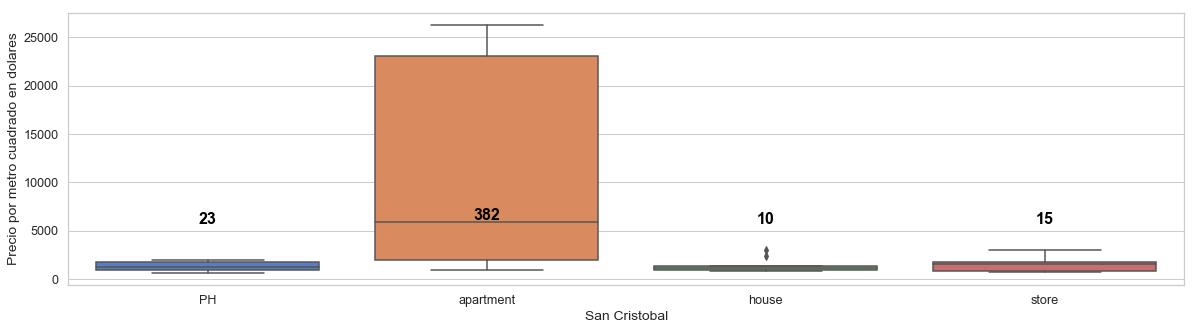

In [62]:
mask_place_name = data.place_name == 'San Cristobal'

plt.subplots(figsize=(20,5))
g = sns.boxplot(x='property_type',y='price_usd_per_m2',data=data.loc[mask_place_name, :],palette='muted')
g.set(xlabel='San Cristobal', ylabel='Precio por metro cuadrado en dolares')

valores = data.loc[mask_place_name, 'property_type'].value_counts().sort_index()
y_valores = 5700

for xtick in g.get_xticks():
    g.text(xtick, valores[xtick]+ y_valores, valores[xtick], horizontalalignment='center',fontsize=16,color='black',weight='bold')

In [63]:
df_final = pd.DataFrame()
mask_place_name = data.place_name == 'San Cristobal'
mask_property_type = data.property_type == 'apartment'
place_name_list = data.loc[mask_place_name&mask_property_type].place_name.unique()
prop_type_list =  data.loc[mask_place_name&mask_property_type].property_type.unique()
for pn in place_name_list:
    for pt in prop_type_list:
        df_temp = remove_outlier(data, 0.25, 0.75, 1.5, 'price_usd_per_m2', pn, 'place_name', pt, 'property_type')
        df_final = df_final.append(df_temp)

In [64]:
# Borro grafico de distribucion de precios San Cristobal apartamento - 1ra pasada outliers - df_final

In [66]:
precio_m2_barrio = df_final.loc[:,['price_usd_per_m2','Id_caso']]
display(precio_m2_barrio.shape)
display(precio_m2_barrio.sort_values(by = [('price_usd_per_m2')], ascending=False).head(10))

(382, 2)

,price_usd_per_m2,Id_caso
6320,26241.64,26396
6274,26136.36,26339
6214,26018.97,26270
6232,25991.55,26291
6125,25967.09,26161
6304,25956.88,26379
6174,25900.73,26216
6098,25899.70,26123
6242,25896.09,26302
6369,25896.09,26505


In [67]:
# LO COMENTO - CELDA MEZCLADA CON APORTE DE NATI - lo mando a seccion de imputacion

# armamos un data con los nulos de precio y solo algunas columnas
#precio_nulo = data.price_usd_per_m2.isnull()
#x = data.loc[precio_nulo,["Id_caso", "place_name", "price_usd_per_m2"]]
#x.set_index("Id_caso", inplace = True)

SEGUN LAS url XXXXX se indica que el precio maximo promedio de metro cuadrado en dolares para el barrio XXXX es de XXXXX, por lo que se decido colocar un tope de precio maximo de 3500 dolares

In [68]:
df_final1 = pd.DataFrame()
mask_precio_max = df_final.price_usd_per_m2 < 3500
mask_place_name = df_final.place_name == 'San Cristobal'
mask_property_type = df_final.property_type == 'apartment'
place_name_list = df_final.loc[mask_place_name&mask_property_type].place_name.unique()
prop_type_list =  df_final.loc[mask_place_name&mask_property_type].property_type.unique()
for pn in place_name_list:
    for pt in prop_type_list:
        df_temp = remove_outlier(df_final.loc[mask_precio_max], 0.10, 0.90, 1.5, 'price_usd_per_m2', pn, 'place_name', pt, 'property_type')
        df_final1 = df_final1.append(df_temp)

In [69]:
# Borro grafico de distribucion de precios San Cristobal apartamento - 2ra pasada outliers - df_final1

In [70]:
precio_m2_barrio = df_final1.loc[:,['price_usd_per_m2','Id_caso']]
display(precio_m2_barrio.shape)
display(precio_m2_barrio.sort_values(by = [('price_usd_per_m2')], ascending=False).head(10))

(170, 2)

,price_usd_per_m2,Id_caso
27626,3142.86,114468
10829,3125.00,45002
19629,3121.95,79116
5729,2995.00,25660
1013,2962.96,6433
5757,2840.00,25691
5761,2782.50,25695
6592,2651.16,27131
10592,2627.12,44136
9582,2612.50,39777


In [71]:
# borro todos los de San Cristobal / Departamento
mask_place_name = data.place_name == 'San Cristobal'
mask_property_type = data.property_type == 'apartment'
data = data.drop(data.loc[mask_place_name&mask_property_type].index)

In [72]:
# append todos los de San Cristobal / Departamento nuevos (sin outliers)
data = data.append(df_final1)

In [75]:
# valido
mask_place_name = data.place_name == 'San Cristobal'
mask_property_type = data.property_type == 'apartment'
display(data.loc[mask_place_name&mask_property_type].head(3))
display(data.loc[mask_place_name&mask_property_type].shape)

,Id_caso,property_type,place_with_parent_names,country_name,state_name,lat-lon,lat,lon,price,currency,...,pn_Villa Lugano,pn_Villa Luro,pn_Villa Ortuzar,pn_Villa Pueyrredón,pn_Villa Real,pn_Villa Riachuelo,pn_Villa Santa Rita,pn_Villa Soldati,pn_Villa Urquiza,pn_Villa del Parque
151,696,apartment,|Argentina|Capital Federal|San Cristobal|,Argentina,Capital Federal,"-34.62395,-58.3959922",-34.623950,-58.395992,115000.0,USD,...,0,0,0,0,0,0,0,0,0,0
315,1532,apartment,|Argentina|Capital Federal|San Cristobal|,Argentina,Capital Federal,"-34.618949,-58.3944713",-34.618949,-58.394471,80000.0,USD,...,0,0,0,0,0,0,0,0,0,0
538,4315,apartment,|Argentina|Capital Federal|San Cristobal|,Argentina,Capital Federal,"-34.6244262,-58.3973636",-34.624426,-58.397364,85000.0,USD,...,0,0,0,0,0,0,0,0,0,0


(170, 102)

In [77]:
#+++++++++++++++++++++++++++++++
#validacion general
#++++++++++++++++++++++++++++++++

precio_m2_barrio = data.groupby(['place_name','property_type']).agg({'price_usd_per_m2':  ['max']})
display(precio_m2_barrio.shape)
display(precio_m2_barrio.sort_values(by = [('price_usd_per_m2', 'max')], ascending=False).head(10))


(212, 1)

price_usd_per_m2
                                         max
place_name    property_type                 
Once          store                 22000.00
San Nicolás   store                 16250.00
Barrio Norte  store                 15833.33
Villa Crespo  store                 13181.82
Palermo Chico apartment             12796.21
              house                 12121.21
Recoleta      store                 12035.01
Palermo       apartment             10875.33
Puerto Madero apartment             10479.04
Nuñez         store                 10000.00

In [78]:
data.shape

(20419, 102)

In [80]:
list(data.columns)

['Id_caso',
 'property_type',
 'place_with_parent_names',
 'country_name',
 'state_name',
 'lat-lon',
 'lat',
 'lon',
 'price',
 'currency',
 'price_aprox_local_currency',
 'price_aprox_usd',
 'floor',
 'rooms',
 'expenses',
 'description',
 'title',
 'Pais',
 'Zona',
 'Partido_barrio',
 'Localidad',
 'Obs_localidad',
 'place_name',
 'geonames_id',
 'price_usd_per_m2',
 'price_per_m2',
 'surface_total_in_m2',
 'surface_covered_in_m2',
 'cochera',
 'piscina',
 'parrilla',
 'baulera',
 'balcon',
 'terraza',
 'jardin',
 'lavadero',
 'subte',
 'seguridad',
 'metrobus',
 'prop_type_apartment',
 'prop_type_house',
 'prop_type_store',
 'pn_Agronomía',
 'pn_Almagro',
 'pn_Balvanera',
 'pn_Barracas',
 'pn_Barrio Norte',
 'pn_Belgrano',
 'pn_Boca',
 'pn_Boedo',
 'pn_Caballito',
 'pn_Capital Federal',
 'pn_Centro / Microcentro',
 'pn_Chacarita',
 'pn_Coghlan',
 'pn_Colegiales',
 'pn_Congreso',
 'pn_Constitución',
 'pn_Flores',
 'pn_Floresta',
 'pn_Las Cañitas',
 'pn_Liniers',
 'pn_Mataderos',
 'p

---

### Imputaciones

Caracteristicas:

Variables a imputar: `surface_covered_in_m2`, `surface_total_in_m2`, `price_usd_per_m2`, `price_per_m2`

Imputacion por mediana, segmentado por barrio y tipo de propiedad.

Criterio de imputacion:
 * Para que se aplique la imputacion el porcentaje de nulos por barrio menor al 25% 
 * Desvio estandar menor o igual a la mitad de la mediana del desvio estandar del tipo de propiedad por barrio.
   
Se busca garantizar la maxima representatibidad de los datos a imputar.

In [81]:
display(data.surface_covered_in_m2.isnull().value_counts())
display(data.surface_total_in_m2.isnull().value_counts())
display(data.price_usd_per_m2.isnull().value_counts())
display(data.price_per_m2.isnull().value_counts())

False    20419
Name: surface_covered_in_m2, dtype: int64

False    20419
Name: surface_total_in_m2, dtype: int64

False    20419
Name: price_usd_per_m2, dtype: int64

False    20419
Name: price_per_m2, dtype: int64

In [22]:
# Nulos de precio y superficie para revisar imputacion

price_usd_per_m2_null = data.price_usd_per_m2.isnull()
surface_total_in_m2_null = data.surface_total_in_m2.isnull()
surface_covered_in_m2_null = data.surface_covered_in_m2.isnull()
price_per_m2_null = data.price_per_m2.isnull()

In [23]:
nulos = price_usd_per_m2_null | surface_total_in_m2_null | surface_covered_in_m2_null | price_per_m2_null

dfimp = data.loc[nulos, ['Id_caso', 'place_name', 'property_type', 'price_usd_per_m2','price_per_m2','surface_total_in_m2','surface_covered_in_m2']]
dfimp.set_index("Id_caso", inplace = True)

dfimp.sample(3)

,place_name,property_type,price_usd_per_m2,price_per_m2,surface_total_in_m2,surface_covered_in_m2
Id_caso,,,,,,
120817,Caballito,store,NaN,NaN,220.0,220.0
56560,Palermo,apartment,NaN,2696.97,165.0,165.0
57819,San Cristobal,apartment,NaN,2184.21,NaN,38.0


Identificamos los nulos sobre el dataframe de nulos generado

In [24]:
display(dfimp.price_usd_per_m2.isnull().value_counts())
display(dfimp.price_per_m2.isnull().value_counts())
display(dfimp.surface_covered_in_m2.isnull().value_counts())
display(dfimp.surface_total_in_m2.isnull().value_counts())

True     7227
False     837
Name: price_usd_per_m2, dtype: int64

False    5552
True     2512
Name: price_per_m2, dtype: int64

False    6894
True     1170
Name: surface_covered_in_m2, dtype: int64

False    4426
True     3638
Name: surface_total_in_m2, dtype: int64

In [34]:
# cantidad de nulos por barrios

data_porc_nulos = pd.DataFrame(dfimp["place_name"].value_counts())
data_porc_nulos.rename(columns = {"place_name":"nulos"}, inplace = True)
data_porc_todos = pd.DataFrame(data.place_name.value_counts())

#data_porc_todos
data_porc = pd.concat([data_porc_nulos, data_porc_todos], axis = 1)
data_porc["porc"] = (data_porc.nulos/data_porc.place_name * 100).round(2)
data_porc.rename(columns = {"place_name":"total"}, inplace = True)
data_porc.sort_values(by = ["porc"], ascending=False).head(10)

,nulos,total,porc
Catalinas,3,4,75.00
Parque Chas,29,44,65.91
Villa Soldati,9,14,64.29
Versalles,31,55,56.36
Liniers,204,386,52.85
Villa Santa Rita,29,56,51.79
Pompeya,31,60,51.67
Villa Riachuelo,3,6,50.00
Parque Avellaneda,25,56,44.64
Villa Lugano,85,200,42.50


Proceso imputacion variables numericas continuas

In [30]:
col_imputacion = ['price_usd_per_m2','price_per_m2', 'surface_covered_in_m2', 'surface_total_in_m2']

for c in col_imputacion:
    for b in data.place_name.unique():
        for p in list(data.loc[data.place_name == b, 'property_type'].value_counts().index):
            barrio_prop_imp = data.loc[data.property_type == p, :].groupby('place_name')[c]
            if (data_porc.loc[data_porc.index == b, 'porc'][0] <= 25.00) & (barrio_prop_imp.std()[b] < barrio_prop_imp.std().median() / 1.5): # mediana de desvios
                
                nulos = dfimp[c].isnull()
                barrio = dfimp.place_name == b
                propiedad = dfimp.property_type == p
                dfimp.loc[nulos & barrio & propiedad, c] = barrio_prop_imp.median()[b]

In [35]:
display(dfimp.price_usd_per_m2.isnull().value_counts())
display(dfimp.price_per_m2.isnull().value_counts())
display(dfimp.surface_covered_in_m2.isnull().value_counts())
display(dfimp.surface_total_in_m2.isnull().value_counts())

True     7208
False     856
Name: price_usd_per_m2, dtype: int64

False    5614
True     2450
Name: price_per_m2, dtype: int64

False    6904
True     1160
Name: surface_covered_in_m2, dtype: int64

False    4449
True     3615
Name: surface_total_in_m2, dtype: int64

In [29]:
# armamos df con los valores imputados para concatenar al data original
data.set_index("Id_caso", inplace = True)

# dfimp - 'price_usd_per_m2'
dfimp_price_usd_per_m2 = dfimp.drop(['place_name','property_type','price_per_m2','surface_total_in_m2','surface_covered_in_m2' ],axis=1)
dfimp_price_usd_per_m2.rename(columns = {'price_usd_per_m2': 'price_usd_per_m2_imputado'}, inplace=True)
data_imputac = pd.concat([data, dfimp_price_usd_per_m2], axis = 1)

# dfimp - 'price_per_m2'
dfimp_price_per_m2 = dfimp.drop(['place_name','property_type', 'price_usd_per_m2','surface_total_in_m2','surface_covered_in_m2'],axis=1)
dfimp_price_per_m2.rename(columns = {'price_per_m2': 'price_per_m2_imputado'}, inplace=True)
data_imputac = pd.concat([data, dfimp_price_per_m2], axis = 1)

# dfimp - 'surface_total_in_m2'
dfimp_surface_total_in_m2 = dfimp.drop(['place_name','property_type', 'price_usd_per_m2','price_per_m2','surface_covered_in_m2'],axis=1)
dfimp_surface_total_in_m2.rename(columns = {'surface_total_in_m2': 'surface_total_in_m2_imputado'}, inplace=True)
data_imputac = pd.concat([data, dfimp_surface_total_in_m2], axis = 1)

# dfimp - 'surface_covered_in_m2'
dfimp_surface_covered_in_m2 = dfimp.drop(['place_name','property_type', 'price_usd_per_m2','price_per_m2', 'surface_total_in_m2'],axis=1)
dfimp_surface_covered_in_m2.rename(columns = {'surface_covered_in_m2': 'surface_covered_in_m2_imputado'}, inplace=True)
data_imputac = pd.concat([data, dfimp_surface_covered_in_m2], axis = 1)
data_imputac.drop(['surface_covered_in_m2_imputado'],axis=1, inplace=True)

In [30]:
data_imputac.columns

Index(['property_type', 'place_with_parent_names', 'country_name',
       'state_name', 'lat-lon', 'lat', 'lon', 'price', 'currency',
       'price_aprox_local_currency', 'price_aprox_usd', 'floor', 'rooms',
       'expenses', 'description', 'title', 'Pais', 'Zona', 'Partido_barrio',
       'Localidad', 'Obs_localidad', 'place_name', 'geonames_id',
       'price_usd_per_m2', 'price_per_m2', 'surface_total_in_m2',
       'surface_covered_in_m2', 'cochera', 'piscina', 'parrilla', 'baulera',
       'balcon', 'terraza', 'jardin', 'lavadero', 'subte', 'seguridad',
       'metrobus'],
      dtype='object')

In [31]:
data_imputac.shape

(29380, 38)

In [32]:
# imputamos los nulos de mt2 totales con los valores de mt2 cubiertos y lo mismo para las columnas de precio:

super_cub_no_nulo = data.surface_covered_in_m2.notnull()
data.loc[super_cub_no_nulo, "surface_total_in_m2"] = data.loc[super_cub_no_nulo, "surface_covered_in_m2"]

In [33]:
data = data_imputac.reset_index()

In [34]:
data.columns

Index(['Id_caso', 'property_type', 'place_with_parent_names', 'country_name',
       'state_name', 'lat-lon', 'lat', 'lon', 'price', 'currency',
       'price_aprox_local_currency', 'price_aprox_usd', 'floor', 'rooms',
       'expenses', 'description', 'title', 'Pais', 'Zona', 'Partido_barrio',
       'Localidad', 'Obs_localidad', 'place_name', 'geonames_id',
       'price_usd_per_m2', 'price_per_m2', 'surface_total_in_m2',
       'surface_covered_in_m2', 'cochera', 'piscina', 'parrilla', 'baulera',
       'balcon', 'terraza', 'jardin', 'lavadero', 'subte', 'seguridad',
       'metrobus'],
      dtype='object')

In [35]:
data.sample(3)

,Id_caso,property_type,place_with_parent_names,country_name,state_name,lat-lon,lat,lon,price,currency,...,piscina,parrilla,baulera,balcon,terraza,jardin,lavadero,subte,seguridad,metrobus
18053,73961,apartment,|Argentina|Capital Federal|Belgrano|,Argentina,Capital Federal,"-34.5639010429,-58.4667872223",-34.563901,-58.466787,365000.0,USD,...,1.0,1.0,0.0,1,1.0,0.0,0.0,0.0,0.0,0.0
23893,96353,apartment,|Argentina|Capital Federal|Caballito|,Argentina,Capital Federal,NaN,NaN,NaN,186015.0,USD,...,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0
2933,14497,apartment,|Argentina|Capital Federal|Palermo|,Argentina,Capital Federal,"-34.589231,-58.4100648",-34.589231,-58.410065,390000.0,USD,...,0.0,0.0,1.0,1,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
data.shape

(29380, 39)

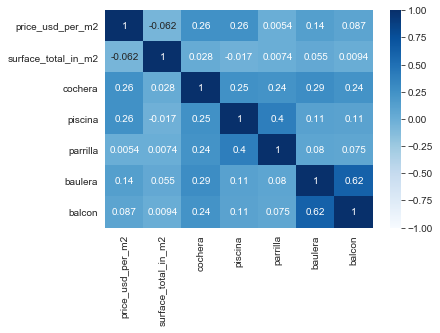

In [69]:
sns.heatmap(data.loc[:, [
 'price_usd_per_m2',
 'surface_total_in_m2',
 'cochera',
 'piscina',
 'parrilla',
 'baulera',
 'balcon'
]].corr(), annot=True, vmin=-1, cmap='Blues');

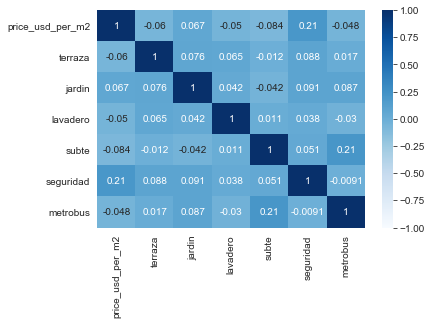

In [70]:
sns.heatmap(data.loc[:, ['price_usd_per_m2',
 'terraza',
 'jardin',
 'lavadero',
 'subte',
 'seguridad',
 'metrobus']].corr(), annot=True, vmin=-1, cmap='Blues');

---

### Eliminacion de nulos y columnas sin uso

In [82]:
caba_place_name_mask = data.place_name != 'Capital Federal'
surface_total_in_m2_notnull = data.surface_total_in_m2.notnull()
surface_covered_mask_notnull = data.surface_covered_in_m2.notnull()
price_usd_per_m2_mask_notnull = data.price_usd_per_m2.notnull()

In [83]:
data = data.loc[caba_place_name_mask & surface_covered_mask_notnull & surface_total_in_m2_notnull & price_usd_per_m2_mask_notnull]

In [84]:
data.shape

(20193, 102)

In [85]:
erase_columns = ['property_type', 'place_with_parent_names', 'country_name', 'price_per_m2','state_name', 'lat-lon', 'lat', 'lon', 'price', 'currency',
       'price_aprox_local_currency', 'expenses', 'description', 'title', 'Pais', 'Zona', 'Partido_barrio',
       'Localidad', 'Obs_localidad', 'place_name']

In [86]:
data = data.drop(data[erase_columns], axis=1)

In [87]:
data.columns

Index(['Id_caso', 'price_aprox_usd', 'floor', 'rooms', 'geonames_id',
       'price_usd_per_m2', 'surface_total_in_m2', 'surface_covered_in_m2',
       'cochera', 'piscina', 'parrilla', 'baulera', 'balcon', 'terraza',
       'jardin', 'lavadero', 'subte', 'seguridad', 'metrobus',
       'prop_type_apartment', 'prop_type_house', 'prop_type_store',
       'pn_Agronomía', 'pn_Almagro', 'pn_Balvanera', 'pn_Barracas',
       'pn_Barrio Norte', 'pn_Belgrano', 'pn_Boca', 'pn_Boedo', 'pn_Caballito',
       'pn_Capital Federal', 'pn_Centro / Microcentro', 'pn_Chacarita',
       'pn_Coghlan', 'pn_Colegiales', 'pn_Congreso', 'pn_Constitución',
       'pn_Flores', 'pn_Floresta', 'pn_Las Cañitas', 'pn_Liniers',
       'pn_Mataderos', 'pn_Monserrat', 'pn_Monte Castro', 'pn_Nuñez',
       'pn_Once', 'pn_Palermo', 'pn_Palermo Chico', 'pn_Palermo Hollywood',
       'pn_Palermo Soho', 'pn_Palermo Viejo', 'pn_Parque Avellaneda',
       'pn_Parque Centenario', 'pn_Parque Chacabuco', 'pn_Parque Chas',
    

---

In [88]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [89]:

model = LinearRegression(fit_intercept=True)

feature_cols = ['cochera', 'piscina',
       'parrilla', 'baulera', 'balcon', 'terraza', 'jardin', 'lavadero',
       'prop_type_apartment', 'prop_type_house', 'prop_type_store',
       'pn_Agronomía', 'pn_Almagro', 'pn_Balvanera', 'pn_Barracas',
       'pn_Barrio Norte', 'pn_Belgrano', 'pn_Boca', 'pn_Boedo', 'pn_Caballito',
       'pn_Centro / Microcentro', 'pn_Chacarita', 'pn_Coghlan',
       'pn_Colegiales', 'pn_Congreso', 'pn_Constitución', 'pn_Flores',
       'pn_Floresta', 'pn_Las Cañitas', 'pn_Liniers', 'pn_Mataderos',
       'pn_Monserrat', 'pn_Monte Castro', 'pn_Nuñez', 'pn_Once', 'pn_Palermo',
       'pn_Palermo Chico', 'pn_Palermo Hollywood', 'pn_Palermo Soho',
       'pn_Palermo Viejo', 'pn_Parque Avellaneda', 'pn_Parque Centenario',
       'pn_Parque Chacabuco', 'pn_Parque Chas', 'pn_Parque Patricios',
       'pn_Paternal', 'pn_Pompeya', 'pn_Puerto Madero', 'pn_Recoleta',
       'pn_Retiro', 'pn_Saavedra', 'pn_San Cristobal', 'pn_San Nicolás',
       'pn_San Telmo', 'pn_Tribunales', 'pn_Velez Sarsfield', 'pn_Versalles',
       'pn_Villa Crespo', 'pn_Villa Devoto', 'pn_Villa General Mitre',
       'pn_Villa Lugano', 'pn_Villa Luro', 'pn_Villa Ortuzar',
       'pn_Villa Pueyrredón', 'pn_Villa Real', 'pn_Villa Riachuelo',
       'pn_Villa Santa Rita', 'pn_Villa Soldati', 'pn_Villa Urquiza',
       'pn_Villa del Parque']
X = data[feature_cols]
y = data.price_usd_per_m2

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=1)

scaler = StandardScaler()
scaler.fit_transform(Xtrain)

model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)
ypred_train = model.predict(Xtrain)

print ('MAE:', mean_absolute_error(ytest, ypred).round(2))
print ('MSE:', mean_squared_error(ytest, ypred).round(2))
print ('RMSE:', np.sqrt(mean_squared_error(ytest, ypred)).round(2))
print ('R2:', r2_score(ytest, ypred).round(2))

MAE: 526.61
MSE: 627307.47
RMSE: 792.03
R2: 0.53


In [90]:
r2_score(ytrain, ypred_train).round(2)

0.52

Fin depuracion dataframe y prueba inicial
---

---